<a href="https://colab.research.google.com/github/EisaacJC/Deep-Learning-4-CV/blob/main/Autoencoders_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project On Deep Learning 4 Computer Vision - Autoencoders

## Emmanuel Isaac Juárez Caballero

## Introduction

Generative models have become fundamental tools in unsupervised learning and anomaly detection. In this implementation, we focus on Variational Autoencoders (VAEs) with comparisons to traditional architectures, incorporating multiple detection methodologies for robust anomaly identification. Our approach combines the generative capabilities of VAEs with ensemble-based outlier detection mechanisms.

In [1]:
%%capture
!pip install pytorch_msssim
!pip install umap
!pip install optuna  # Instalar las bibliotecas necesarias

## Architecture Design
- Variational Autoencoder Implementation
The core VAE architecture employs a β-VAE framework, which introduces a balancing coefficient β to the standard VAE objective function:
$L(\theta, \varphi) = E[log p_\theta(x|z)] - β * D_KL(q_\varphi(z|x) || p(z))$

Three distinct encoder architectures were implemented:

- Convolutional Encoder:

    - Sequential convolutional layers with batch normalization
    - Progressive dimensionality reduction (32→64→128→256 channels)
    - GELU activation functions for improved gradient flow


- ResNet-based Encoder:
    - Residual connections for gradient propagation
    - Two residual blocks with identity mappings
    - Channel progression: 64→128 with spatial reduction


- Dense Encoder:

    - Hybrid architecture combining convolution and dense layers
    - Three convolutional stages followed by dense layers
    - Reduced parameter count through progressive compression



- Decoder Architecture
    - A unified decoder architecture was maintained across all variants to isolate encoder effects:

    - Transposed convolutions for upsampling
    - Batch normalization layers after each convolution
    - Tanh activation in the output layer for normalized reconstructions

## Outlier Detection Framework
The implementation incorporates multiple detection strategies:

- Reconstruction-based Detection:

    - MSE-based reconstruction error scoring
    - Gaussian likelihood estimation in latent space
    - Structural Similarity Index (SSIM) for perceptual differences


- Statistical Detection Methods:

    - Local Outlier Factor (LOF) with adaptive neighborhood sizing
    - Isolation Forest for implicit density estimation
    - One-Class SVM with RBF kernel


- Ensemble Integration:

    - Weighted voting mechanism across detectors
    - Score normalization using Z-score standardization
    - Confidence thresholding for final predictions

# Complete execution (takes a lot to execute)

This code creates all the

In [4]:
import matplotlib.pyplot as plt
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import os
from pytorch_msssim import ssim
from sklearn.covariance import EllipticEnvelope
os.makedirs('vae_outputs', exist_ok=True)
#torch.manual_seed(42)
#np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.GELU()
        )
        self.flatten_size = 256 * 2 * 2
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flatten_size)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class DeConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 2, 2)
        return self.decoder(x)

class BetaVAE(nn.Module):
    def __init__(self, encoder, decoder, beta=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = nn.MSELoss(reduction='mean')(recon_x, x)
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kld_loss, recon_loss, kld_loss

class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def add_gaussian_noise(x, sigma):
    return torch.clamp(x + torch.randn_like(x) * sigma, -1, 1)

def add_salt_pepper_noise(x, p):
    noise_mask = torch.rand_like(x) < p
    noise = 2 * torch.randint_like(noise_mask, 0, 2).float() - 1
    return torch.where(noise_mask, noise, x)

def save_image_grid(tensor, filename, nrow=8, padding=2):
    """Guardar una cuadrícula de imágenes en un archivo"""
    grid = make_grid(tensor, nrow=nrow, padding=padding, normalize=True)
    save_image(grid, filename, padding=padding)

def visualize_reconstructions(model, data_loader, epoch, noise_type=None, noise_param=None):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images[:32].to(device)

        if noise_type == 'gaussian':
            noisy_images = add_gaussian_noise(images, noise_param)
        elif noise_type == 'salt_pepper':
            noisy_images = add_salt_pepper_noise(images, noise_param)
        else:
            noisy_images = images

        recon_images, _, _ = model(noisy_images)
        save_image_grid(images, f'vae_outputs/epoch_{epoch}_original.png')

        if noise_type:
            save_image_grid(noisy_images, f'vae_outputs/epoch_{epoch}_noisy.png')

        save_image_grid(recon_images, f'vae_outputs/epoch_{epoch}_reconstructed.png')

def visualize_interpolations(model, data_loader, epoch):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        img1, img2 = images[0:1].to(device), images[1:2].to(device)
        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)

        alphas = np.linspace(0, 1, 8)
        interpolated_images = []
        for alpha in alphas:
            mu_interp = mu1 * (1 - alpha) + mu2 * alpha
            decoded = model.decoder(mu_interp)
            interpolated_images.append(decoded)

        all_images = torch.cat([img1] + interpolated_images + [img2], dim=0)
        save_image_grid(all_images, f'vae_outputs/epoch_{epoch}_interpolation.png', nrow=10)

def plot_training_curves(train_losses, test_losses, recon_losses, kld_losses):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(kld_losses, label='KLD Loss')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('vae_outputs/training_curves.png')
    plt.close()

def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs):
    train_losses = []
    test_losses = []
    recon_losses = []
    kld_losses = []
    best_test_loss = float('inf')
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_kld_loss = 0

        for data, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = data.to(device)
            optimizer.zero_grad()

            if np.random.rand() < 0.5:
                data_input = add_gaussian_noise(data, 0.2)
            else:
                data_input = add_salt_pepper_noise(data, 0.15)

            recon_batch, mu, logvar = model(data_input)
            loss, recon_loss, kld_loss = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld_loss += kld_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kld_loss = epoch_kld_loss / len(train_loader)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        recon_losses.append(avg_recon_loss)
        kld_losses.append(avg_kld_loss)

        if epoch % 5 == 0:
            visualize_reconstructions(model, test_loader, epoch)
            visualize_reconstructions(model, test_loader, epoch, 'gaussian', 0.2)
            visualize_interpolations(model, test_loader, epoch)
            plot_training_curves(train_losses, test_losses, recon_losses, kld_losses)

        scheduler.step(avg_test_loss)
        early_stopping(avg_test_loss)

        if early_stopping.early_stop:
            print("Parada temprana activada")
            break

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), 'vae_outputs/best_model.pth')

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

class ArchitectureOptimizer:
    def __init__(self, n_trials=5):
        self.n_trials = n_trials

    def define_model(self, trial):
        latent_dim = trial.suggest_int('latent_dim', 32, 512)
        beta = trial.suggest_float('beta', 0.01, 1.0)
        learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
        encoder = ConvEncoder(latent_dim=latent_dim)
        decoder = DeConvDecoder(latent_dim=latent_dim)
        return encoder, decoder, batch_size, learning_rate

    def objective(self, trial, trainset, testset, n_epochs=5):
        encoder, decoder, batch_size, learning_rate = self.define_model(trial)

        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

        model = BetaVAE(encoder, decoder, beta=trial.suggest_float('beta', 0.01, 1.0))
        model = model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        best_test_loss = float('inf')
        for epoch in range(n_epochs):
            model.train()
            for data, _ in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss, _, _ = model.loss_function(recon_batch, data, mu, logvar)
                loss.backward()
                optimizer.step()

            test_loss = self.evaluate(model, test_loader)
            best_test_loss = min(best_test_loss, test_loss)

            trial.report(test_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return best_test_loss

    def evaluate(self, model, test_loader):
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()
        return test_loss / len(test_loader)

class OutlierDetector:
    def __init__(self, model, contamination=0.1):
        self.model = model
        self.detector = EllipticEnvelope(contamination=contamination, random_state=42)

    def fit(self, dataloader):
        latent_vectors = self._get_latent_vectors(dataloader)
        self.detector.fit(latent_vectors)

    def detect_outliers(self, dataloader):
        latent_vectors = self._get_latent_vectors(dataloader)
        return self.detector.predict(latent_vectors)

    def _get_latent_vectors(self, dataloader):
        self.model.eval()
        latent_vectors = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                mu, _ = self.model.encoder(data)
                latent_vectors.append(mu.cpu().numpy())
        return np.concatenate(latent_vectors)

    def visualize_outliers(self, dataloader, save_path='outliers.png'):
        predictions = self.detect_outliers(dataloader)
        outlier_indices = np.where(predictions == -1)[0]
        all_images = []
        for data, _ in dataloader:
            all_images.append(data)
        all_images = torch.cat(all_images)
        outlier_images =all_images[outlier_indices][:32]
        with torch.no_grad():
            recon_images, _, _ = self.model(outlier_images.to(device))
        comparison = torch.cat([outlier_images, recon_images.cpu()])
        save_image_grid(comparison, save_path, nrow=8)

        return outlier_indices

def optimize_architecture():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False)
    optimizer = ArchitectureOptimizer()
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimizer.objective(trial, trainset, testset), n_trials=optimizer.n_trials)
    best_trial = study.best_trial
    encoder, decoder, _, _ = optimizer.define_model(best_trial)
    model = BetaVAE(encoder, decoder, beta=best_trial.params['beta'])
    #detector = OutlierDetector(model)
    #detector.fit(train_loader)
    #outlier_indices = detector.visualize_outliers(test_loader)

    return model, study, outlier_indices

Usando dispositivo: cuda


In [5]:
#model, study, outliers = optimize_architecture()

# Simplified implementation

This sections aims to describe the behaviour of all the code without tedius executions for parameter optimisation.

This keeps:
    - Visualizations
    - Training vs validation comparisons
    - Comparison of different architectures.
This omits:
    - Parameter optimisation.

In [59]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from torchvision.utils import make_grid
from tqdm import tqdm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import seaborn as sns
import optuna
from pytorch_msssim import ssim

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
class BetaVAE(nn.Module):
    def __init__(self, encoder, decoder, beta=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.beta * KLD, BCE, KLD

# Decoder architecture
class DeConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 3, 4, 2, 1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = torch.tanh(self.deconv2(x))
        return x

In [41]:
# Additional Autoencoder Architectures
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

class ResNetEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.res1 = ResidualBlock(64)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.res2 = ResidualBlock(128)
        self.flatten_size = 128 * 8 * 8
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.res2(x)
        x = x.view(-1, self.flatten_size)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [42]:
class DenseEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)

        self.dense1 = nn.Linear(128 * 4 * 4, 512)
        self.dense2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [49]:
class EnhancedOutlierDetector:
    def __init__(self, model, n_neighbors=20, contamination=0.1):
        self.model = model
        self.contamination = contamination
        self.detectors = {
            'lof': LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination),
            'iforest': IsolationForest(contamination=contamination, random_state=42),
            'ocsvm': OneClassSVM(kernel='rbf', nu=contamination)
        }
        self.scores = {}

    def get_latent_vectors(self, dataloader):
        self.model.eval()
        vectors = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(device)
                mu, _ = self.model.encoder(data)
                vectors.append(mu.cpu().numpy())
        return np.concatenate(vectors)

    def fit(self, dataloader):
        latent_vectors = self.get_latent_vectors(dataloader)
        for name, detector in self.detectors.items():
            self.detectors[name].fit(latent_vectors)

    def detect_outliers(self, dataloader):
        latent_vectors = self.get_latent_vectors(dataloader)
        results = {}
        for name, detector in self.detectors.items():
            if name == 'lof':
                scores = -detector.negative_outlier_factor_
            else:
                scores = detector.score_samples(latent_vectors)
            results[name] = scores
        return results

    def visualize_score_distributions(self, dataloader):
        results = self.detect_outliers(dataloader)

        fig, axes = plt.subplots(len(self.detectors), 1, figsize=(10, 4*len(self.detectors)))
        if len(self.detectors) == 1:
            axes = [axes]

        for idx, (name, scores) in enumerate(results.items()):
            ax = axes[idx]
            sns.histplot(scores, kde=True, ax=ax)
            cutoff = np.percentile(scores, self.contamination * 100)
            ax.axvline(x=cutoff, color='r', linestyle='--',
                      label=f'Cutoff ({self.contamination:.1%} contamination)')

            ax.set_title(f'{name} Score Distribution')
            ax.set_xlabel('Anomaly Score')
            ax.set_ylabel('Count')
            ax.legend()

        plt.tight_layout()
        plt.show()

    def visualize_outliers(self, dataloader, n_samples=10):
        results = self.detect_outliers(dataloader)
        all_images = []
        for data, _ in dataloader:
            all_images.append(data)
        all_images = torch.cat(all_images)
        num_images = len(all_images)
        fig, axes = plt.subplots(len(self.detectors), 2, figsize=(12, 6*len(self.detectors)))

        for idx, (name, scores) in enumerate(results.items()):
            normal_idx = np.argsort(scores)[-min(n_samples, num_images):]
            anomaly_idx = np.argsort(scores)[:min(n_samples, num_images)]
            normal_images = make_grid(all_images[normal_idx], nrow=5, normalize=True)
            anomaly_images = make_grid(all_images[anomaly_idx], nrow=5, normalize=True)
            axes[idx, 0].imshow(normal_images.permute(1, 2, 0).cpu())
            axes[idx, 0].set_title(f'{name} - Normal Samples')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(anomaly_images.permute(1, 2, 0).cpu())
            axes[idx, 1].set_title(f'{name} - Anomalous Samples')
            axes[idx, 1].axis('off')

        plt.tight_layout()
        plt.show()

In [50]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [51]:
def visualize_reconstructions(model, data_loader, title=""):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images[:8].to(device)
        recon_images, _, _ = model(images)
        comparison = torch.cat([images, recon_images])
        grid = make_grid(comparison, nrow=8, normalize=True)
        plt.figure(figsize=(15, 5))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'{title}\nOriginal (top) vs Reconstructed (bottom)')
        plt.axis('off')
        plt.show()


In [52]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for data, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, bce, kld = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

    return {'train_losses': train_losses, 'test_losses': test_losses}



In [53]:
def compare_architectures(trainset, testset, architectures, n_epochs=5):
    results = {}
    for arch_name, (encoder_class, decoder_class) in architectures.items():
        print(f"\nTraining {arch_name} architecture...")
        encoder = encoder_class(latent_dim=64).to(device)
        decoder = DeConvDecoder(latent_dim=64).to(device)
        model = BetaVAE(encoder, decoder, beta=1.0).to(device)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
        test_loader = DataLoader(testset, batch_size=64, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        results[arch_name] = {
            'model': model,
            'metrics': train_model(model, train_loader, test_loader, optimizer, n_epochs)
        }
        print(f"\nResults for {arch_name}:")
        visualize_reconstructions(model, test_loader, title=f"{arch_name} Architecture")
    return results

Files already downloaded and verified
Files already downloaded and verified

Training conv architecture...


Epoch 1/5: 100%|██████████| 782/782 [00:15<00:00, 50.24it/s]


Epoch 1: Train Loss = 38227.0536, Test Loss = 17701.6257


Epoch 2/5: 100%|██████████| 782/782 [00:15<00:00, 50.84it/s]


Epoch 2: Train Loss = 15348.7390, Test Loss = 16649.2297


Epoch 3/5: 100%|██████████| 782/782 [00:15<00:00, 50.21it/s]


Epoch 3: Train Loss = 14983.2668, Test Loss = 15164.6199


Epoch 4/5: 100%|██████████| 782/782 [00:15<00:00, 50.33it/s]


Epoch 4: Train Loss = 14646.0835, Test Loss = 14627.3867


Epoch 5/5: 100%|██████████| 782/782 [00:15<00:00, 50.59it/s]


Epoch 5: Train Loss = 14480.3914, Test Loss = 18366.4874

Results for conv:


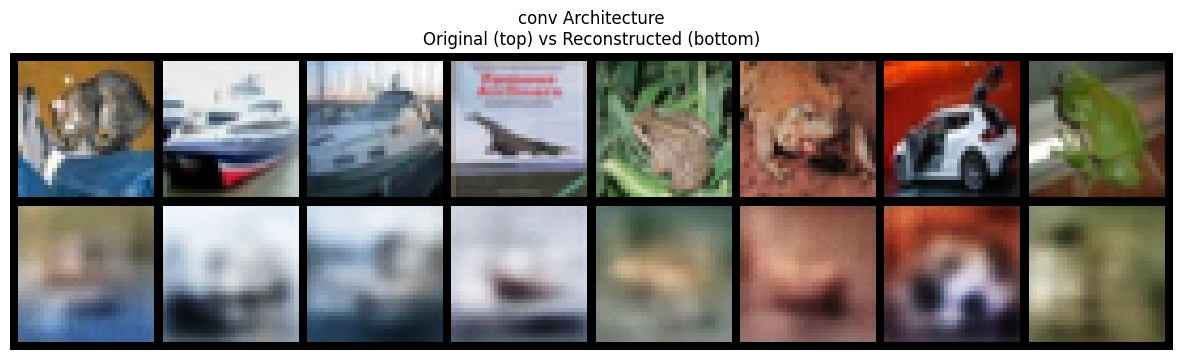


Training resnet architecture...


Epoch 1/5: 100%|██████████| 782/782 [00:17<00:00, 45.49it/s]


Epoch 1: Train Loss = 22650.0456, Test Loss = 18005.4021


Epoch 2/5: 100%|██████████| 782/782 [00:16<00:00, 46.14it/s]


Epoch 2: Train Loss = 14792.4649, Test Loss = 13871.1257


Epoch 3/5: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]


Epoch 3: Train Loss = 13840.7488, Test Loss = 14174.7338


Epoch 4/5: 100%|██████████| 782/782 [00:16<00:00, 46.04it/s]


Epoch 4: Train Loss = 13506.3055, Test Loss = 13351.5987


Epoch 5/5: 100%|██████████| 782/782 [00:17<00:00, 45.84it/s]


Epoch 5: Train Loss = 13242.7026, Test Loss = 12851.5836

Results for resnet:


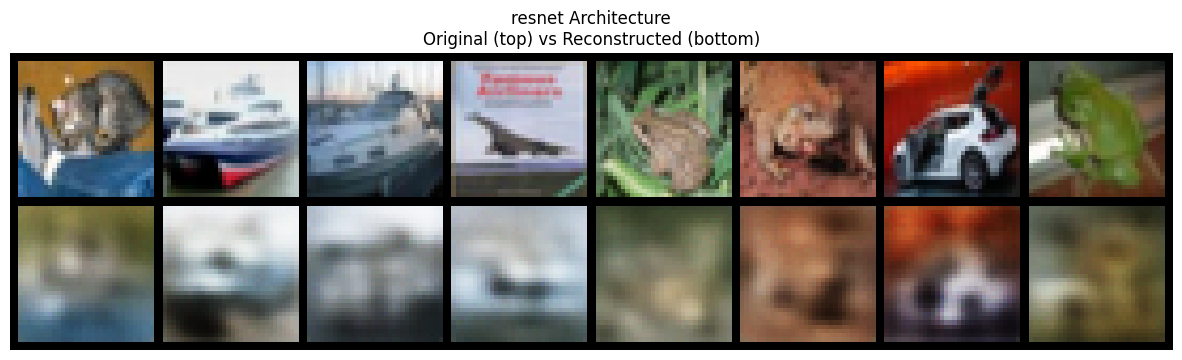


Training dense architecture...


Epoch 1/5: 100%|██████████| 782/782 [00:15<00:00, 49.82it/s]


Epoch 1: Train Loss = 917388.2509, Test Loss = 20938.2435


Epoch 2/5: 100%|██████████| 782/782 [00:15<00:00, 49.42it/s]


Epoch 2: Train Loss = 18996.3574, Test Loss = 17631.8392


Epoch 3/5: 100%|██████████| 782/782 [00:15<00:00, 49.82it/s]


Epoch 3: Train Loss = 17139.3698, Test Loss = 16788.8239


Epoch 4/5: 100%|██████████| 782/782 [00:15<00:00, 49.56it/s]


Epoch 4: Train Loss = 16551.0537, Test Loss = 16160.1167


Epoch 5/5: 100%|██████████| 782/782 [00:15<00:00, 49.59it/s]


Epoch 5: Train Loss = 16364.2702, Test Loss = 16593.8833

Results for dense:


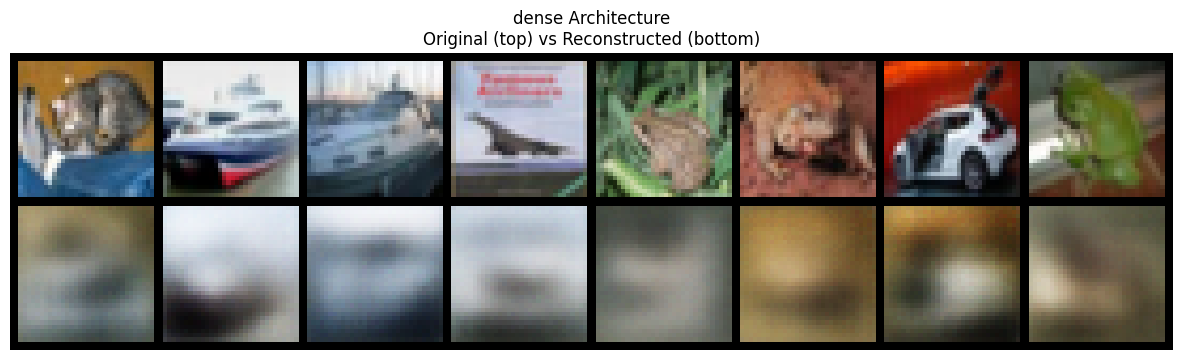

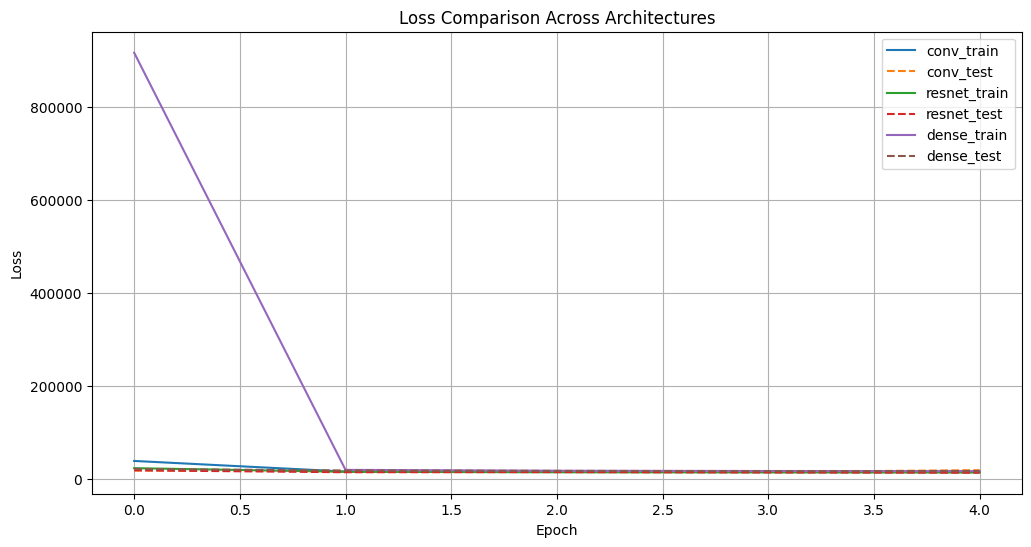


Best performing architecture: resnet


In [55]:
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    architectures = {
        'conv': (ConvEncoder, DeConvDecoder),
        'resnet': (ResNetEncoder, DeConvDecoder),
        'dense': (DenseEncoder, DeConvDecoder)
    }
    results = compare_architectures(trainset, testset, architectures)
    plt.figure(figsize=(12, 6))
    for arch_name, arch_results in results.items():
        metrics = arch_results['metrics']
        plt.plot(metrics['train_losses'], label=f'{arch_name}_train')
        plt.plot(metrics['test_losses'], label=f'{arch_name}_test', linestyle='--')
    plt.title('Loss Comparison Across Architectures')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    best_arch = min(results.items(),
                   key=lambda x: x[1]['metrics']['test_losses'][-1])[0]
    print(f"\nBest performing architecture: {best_arch}")


Best performing architecture: resnet

Fitting outlier detector...

Visualizing outliers...


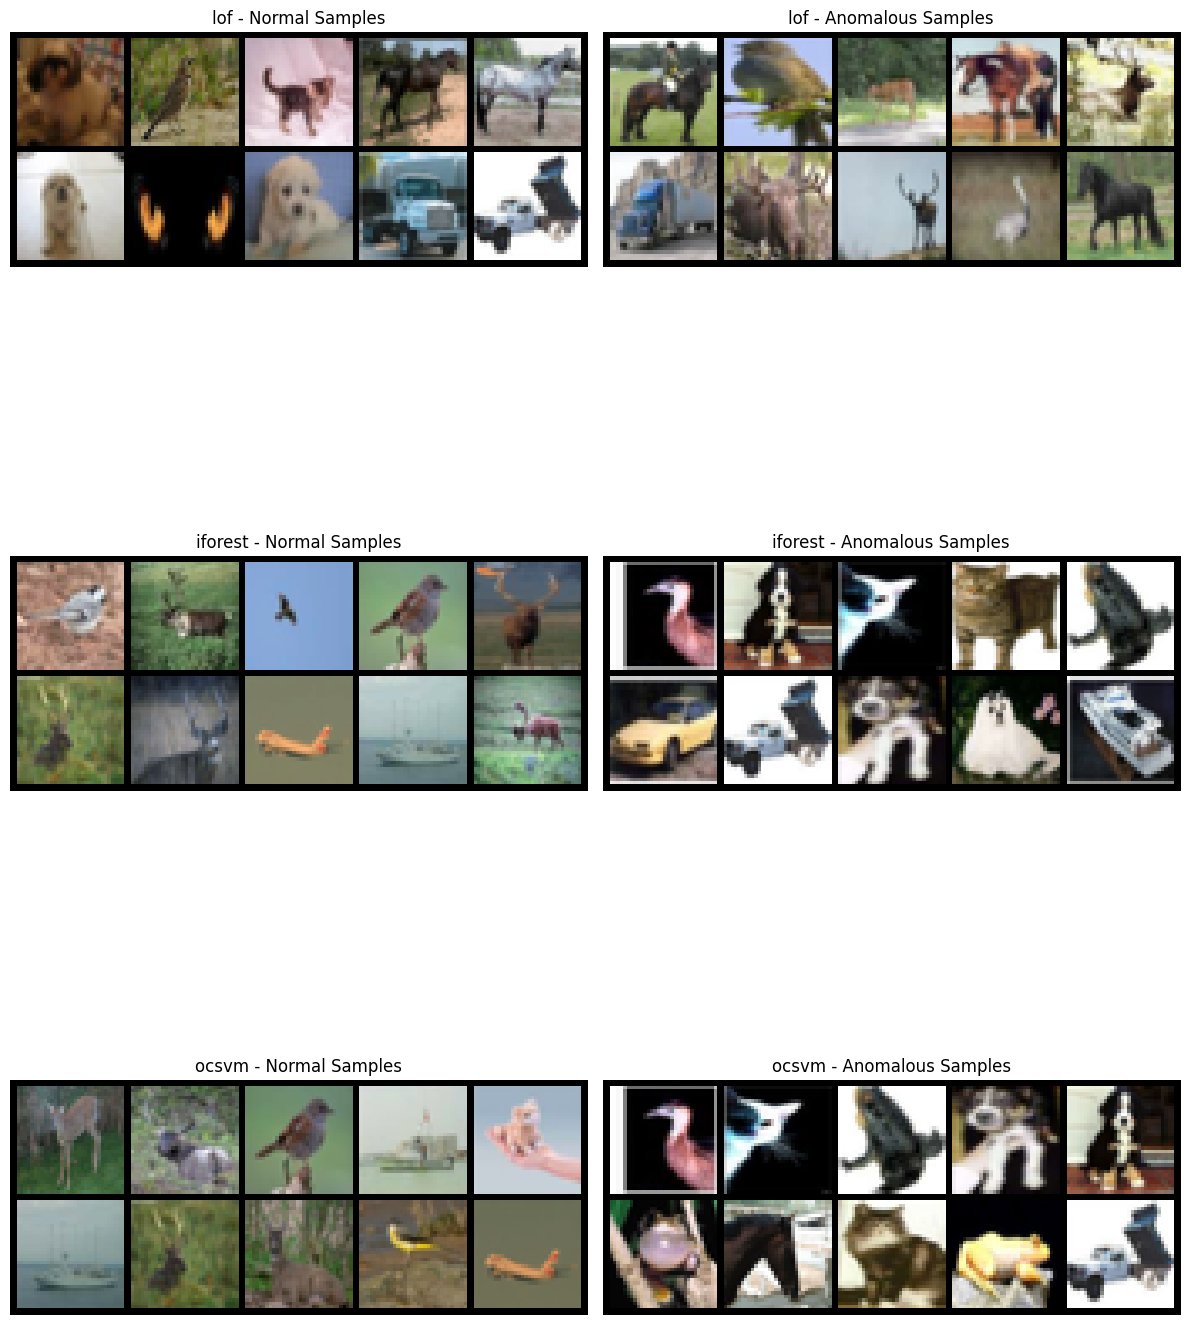

In [60]:
best_arch = min(results.items(),
                   key=lambda x: x[1]['metrics']['test_losses'][-1])[0]
print(f"\nBest performing architecture: {best_arch}")
best_model = results[best_arch]['model']
detector = EnhancedOutlierDetector(best_model)
subset_size = 1000  # Adjust based on your available memory
subset_indices_train = torch.randperm(len(trainset))[:subset_size]
subset_indices_test = torch.randperm(len(testset))[:subset_size]

subset_train = torch.utils.data.Subset(trainset, subset_indices_train)
subset_test = torch.utils.data.Subset(testset, subset_indices_test)

train_loader_outlier = DataLoader(subset_train, batch_size=32, shuffle=False)
test_loader_outlier = DataLoader(subset_test, batch_size=32, shuffle=False)

print("\nFitting outlier detector...")
detector.fit(train_loader_outlier)
print("\nVisualizing outliers...")
detector.visualize_outliers(test_loader_outlier)

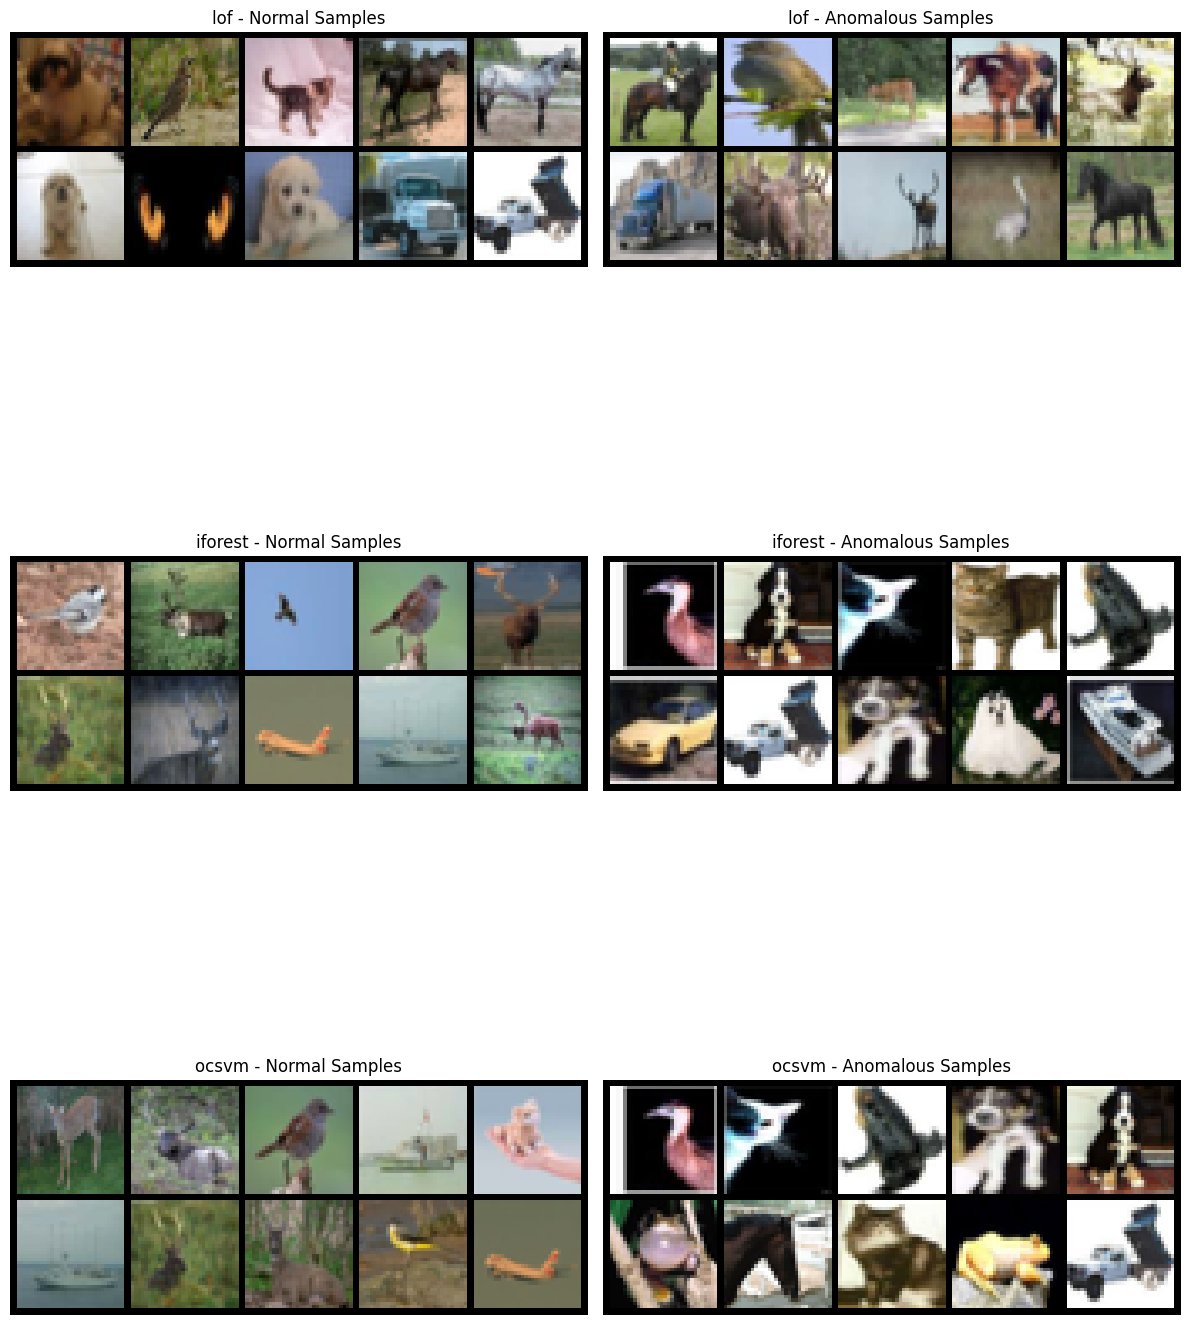

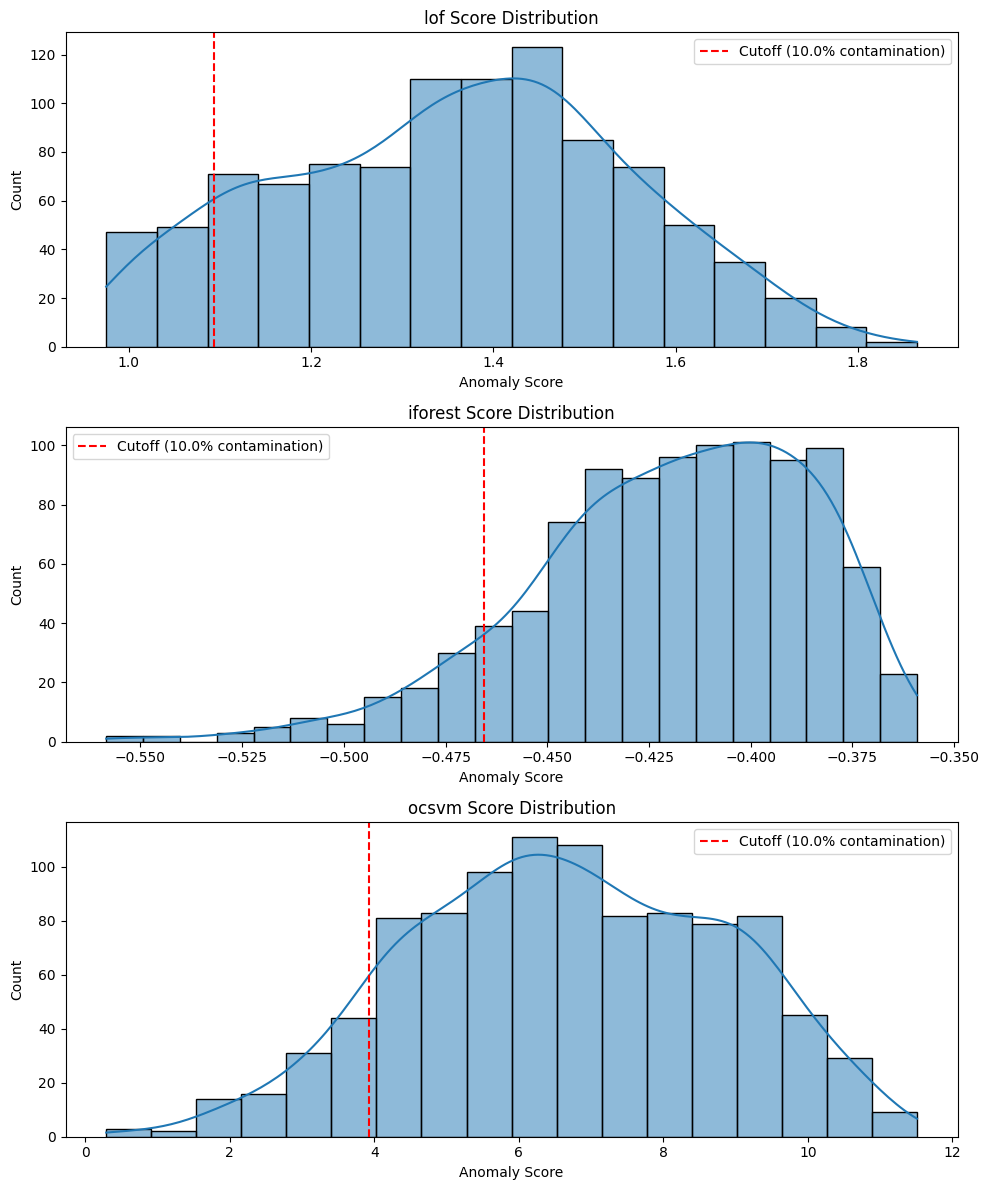

In [61]:
detector.visualize_outliers(test_loader_outlier)
detector.visualize_score_distributions(test_loader_outlier)

# A full execution without parameter search

In [23]:
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
from torchvision.transforms import ToPILImage
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

class VAEVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.to_pil = ToPILImage()

    def show_reconstruction(self, data_loader, noise_type=None, noise_param=None):
        """Display original and reconstructed images side by side"""
        self.model.eval()
        with torch.no_grad():
            images, _ = next(iter(data_loader))
            images = images[:8].to(self.device)
            if noise_type == 'gaussian':
                noisy_images = self.add_gaussian_noise(images, noise_param)
            elif noise_type == 'salt_pepper':
                noisy_images = self.add_salt_pepper_noise(images, noise_param)
            else:
                noisy_images = images
            recon_images, _, _ = self.model(noisy_images)

            fig, axes = plt.subplots(3, 8, figsize=(20, 6))
            for i in range(8):
                img = self.denormalize(images[i])
                axes[0, i].imshow(img.permute(1, 2, 0).cpu().numpy())
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_title('Original', size=14)
            for i in range(8):
                img = self.denormalize(noisy_images[i])
                axes[1, i].imshow(img.permute(1, 2, 0).cpu().numpy())
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_title('Noisy' if noise_type else 'Input', size=14)

            for i in range(8):
                img = self.denormalize(recon_images[i])
                axes[2, i].imshow(img.permute(1, 2, 0).cpu().numpy())
                axes[2, i].axis('off')
                if i == 0:
                    axes[2, i].set_title('Reconstructed', size=14)

            plt.tight_layout()
            return fig

    def show_interpolation(self, data_loader, num_steps=8):
        """Show interpolation between two random images in latent space"""
        self.model.eval()
        with torch.no_grad():
            images, _ = next(iter(data_loader))
            img1, img2 = images[0:1].to(self.device), images[1:2].to(self.device)
            mu1, _ = self.model.encoder(img1)
            mu2, _ = self.model.encoder(img2)
            alphas = np.linspace(0, 1, num_steps)
            interp_images = []

            for alpha in alphas:
                mu_interp = mu1 * (1 - alpha) + mu2 * alpha
                decoded = self.model.decoder(mu_interp)
                interp_images.append(decoded)
            all_images = torch.cat([img1] + interp_images + [img2], dim=0)
            grid = vutils.make_grid(all_images, nrow=num_steps+2, padding=2, normalize=True)
            plt.figure(figsize=(15, 3))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.title('Latent Space Interpolation', size=14)
            return plt.gcf()
    """
    This only is functional executing in a local environment
    """
    def show_training_progress(self, log_dir):
        event_acc = EventAccumulator(log_dir)
        event_acc.Reload()
        train_loss = event_acc.Scalars('Loss/train')
        test_loss = event_acc.Scalars('Loss/test')
        recon_loss = event_acc.Scalars('Loss/reconstruction')
        kld_loss = event_acc.Scalars('Loss/KLD')
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        steps, values = zip(*[(s.step, s.value) for s in train_loss])
        axes[0, 0].plot(steps, values)
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].set_xlabel('Steps')
        axes[0, 0].set_ylabel('Loss')
        steps, values = zip(*[(s.step, s.value) for s in test_loss])
        axes[0, 1].plot(steps, values)
        axes[0, 1].set_title('Test Loss')
        axes[0, 1].set_xlabel('Steps')
        axes[0, 1].set_ylabel('Loss')
        steps, values = zip(*[(s.step, s.value) for s in recon_loss])
        axes[1, 0].plot(steps, values)
        axes[1, 0].set_title('Reconstruction Loss')
        axes[1, 0].set_xlabel('Steps')
        axes[1, 0].set_ylabel('Loss')
        steps, values = zip(*[(s.step, s.value) for s in kld_loss])
        axes[1, 1].plot(steps, values)
        axes[1, 1].set_title('KL Divergence Loss')
        axes[1, 1].set_xlabel('Steps')
        axes[1, 1].set_ylabel('Loss')
        plt.tight_layout()
        return fig

    @staticmethod
    def denormalize(x):
        """Denormalize tensor image with mean 0.5 and std 0.5"""
        return x * 0.5 + 0.5

    @staticmethod
    def add_gaussian_noise(x, sigma):
        """Add Gaussian noise to tensor"""
        return torch.clamp(x + torch.randn_like(x) * sigma, -1, 1)

    @staticmethod
    def add_salt_pepper_noise(x, prob):
        """Add salt and pepper noise to tensor"""
        noise_mask = torch.rand_like(x) < prob
        noise = 2 * torch.randint_like(noise_mask, 0, 2).float() - 1
        return torch.where(noise_mask, noise, x)


In [24]:
def visualize_model_results(model, test_loader, log_dir):
    visualizer = VAEVisualizer(model, next(iter(test_loader))[0].device)
    fig1 = visualizer.show_reconstruction(test_loader)
    plt.figure(fig1.number)
    plt.savefig('reconstructions_clean.png')
    fig2 = visualizer.show_reconstruction(test_loader, 'gaussian', 0.2)
    plt.figure(fig2.number)
    plt.savefig('reconstructions_noisy.png')
    fig3 = visualizer.show_interpolation(test_loader)
    plt.figure(fig3.number)
    plt.savefig('interpolations.png')
    fig4 = visualizer.show_training_progress(log_dir)
    plt.figure(fig4.number)
    plt.savefig('training_progress.png')

    return [fig1, fig2, fig3, fig4]

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from tqdm import tqdm
import os
from pytorch_msssim import ssim

In [26]:
os.makedirs('vae_outputs', exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU()
        )
        self.flatten_size = 256 * 2 * 2
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        self.latent_dim = latent_dim

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flatten_size)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class DeConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * 2 * 2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x
class BetaVAE(nn.Module):
    def __init__(self, encoder, decoder, beta=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = nn.MSELoss(reduction='mean')(recon_x, x)
        kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kld_loss, recon_loss, kld_loss

Using device: cuda


In [27]:
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [28]:
def add_gaussian_noise(x, sigma):
    return torch.clamp(x + torch.randn_like(x) * sigma, -1, 1)

def add_salt_pepper_noise(x, p):
    noise_mask = torch.rand_like(x) < p
    noise = 2 * torch.randint_like(noise_mask, 0, 2).float() - 1
    return torch.where(noise_mask, noise, x)

In [29]:
def save_image_grid(tensor, filename, nrow=8, padding=2):
    """Save a grid of images to a file"""
    grid = make_grid(tensor, nrow=nrow, padding=padding, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [30]:
def visualize_reconstructions(model, data_loader, epoch, noise_type=None, noise_param=None):
    """Visualize original and reconstructed images"""
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images[:32].to(device)
        if noise_type == 'gaussian':
            noisy_images = add_gaussian_noise(images, noise_param)
        elif noise_type == 'salt_pepper':
            noisy_images = add_salt_pepper_noise(images, noise_param)
        else:
            noisy_images = images
        recon_images, _, _ = model(noisy_images)
        save_image_grid(images, f'vae_outputs/epoch_{epoch}_original.png')
        if noise_type:
            save_image_grid(noisy_images, f'vae_outputs/epoch_{epoch}_noisy.png')
        save_image_grid(recon_images, f'vae_outputs/epoch_{epoch}_reconstructed.png')

In [31]:
def visualize_interpolations(model, data_loader, epoch):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        img1, img2 = images[0:1].to(device), images[1:2].to(device)
        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)
        alphas = np.linspace(0, 1, 8)
        interpolated_images = []
        for alpha in alphas:
            mu_interp = mu1 * (1 - alpha) + mu2 * alpha
            decoded = model.decoder(mu_interp)
            interpolated_images.append(decoded)
        all_images = torch.cat([img1] + interpolated_images + [img2], dim=0)
        save_image_grid(all_images, f'vae_outputs/epoch_{epoch}_interpolation.png', nrow=10)

In [32]:
def plot_training_curves(train_losses, test_losses, recon_losses, kld_losses):
    """Plot and save training curves"""
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(kld_losses, label='KLD Loss')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('vae_outputs/training_curves.png')
    plt.close()

In [33]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs):
    train_losses = []
    test_losses = []
    recon_losses = []
    kld_losses = []
    best_test_loss = float('inf')
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_recon_loss = 0
        epoch_kld_loss = 0

        for data, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = data.to(device)
            optimizer.zero_grad()
            if np.random.rand() < 0.5:
                data_input = add_gaussian_noise(data, 0.2)
            else:
                data_input = add_salt_pepper_noise(data, 0.15)
            recon_batch, mu, logvar = model(data_input)
            loss, recon_loss, kld_loss = model.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld_loss += kld_loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_kld_loss = epoch_kld_loss / len(train_loader)
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        recon_losses.append(avg_recon_loss)
        kld_losses.append(avg_kld_loss)
        if epoch % 5 == 0:
            visualize_reconstructions(model, test_loader, epoch)
            visualize_reconstructions(model, test_loader, epoch, 'gaussian', 0.2)
            visualize_interpolations(model, test_loader, epoch)
            plot_training_curves(train_losses, test_losses, recon_losses, kld_losses)
        scheduler.step(avg_test_loss)
        early_stopping(avg_test_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), 'vae_outputs/best_model.pth')

        print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}')

In [36]:
def main():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    train_loader = DataLoader(trainset, batch_size=128, shuffle=True,
                            num_workers=2, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=128, shuffle=False,
                           num_workers=2, pin_memory=True)

    latent_dim = 512
    encoder = ConvEncoder(latent_dim=latent_dim)
    decoder = DeConvDecoder(latent_dim=latent_dim)
    model = BetaVAE(encoder, decoder, beta=0.1)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=5,
                                                   verbose=True)

    train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=100)

In [37]:
if __name__ == '__main__':
    main()

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/100: 100%|██████████| 391/391 [00:11<00:00, 34.35it/s]


Epoch 1: Train Loss = 0.1439, Test Loss = 0.0990


Epoch 2/100: 100%|██████████| 391/391 [00:11<00:00, 32.59it/s]


Epoch 2: Train Loss = 0.0847, Test Loss = 0.0762


Epoch 3/100: 100%|██████████| 391/391 [00:11<00:00, 33.84it/s]


Epoch 3: Train Loss = 0.0719, Test Loss = 0.0685


Epoch 4/100: 100%|██████████| 391/391 [00:11<00:00, 34.45it/s]


Epoch 4: Train Loss = 0.0666, Test Loss = 0.0636


Epoch 5/100: 100%|██████████| 391/391 [00:11<00:00, 34.38it/s]


Epoch 5: Train Loss = 0.0635, Test Loss = 0.0620


Epoch 6/100: 100%|██████████| 391/391 [00:11<00:00, 33.63it/s]


Epoch 6: Train Loss = 0.0617, Test Loss = 0.0603


Epoch 7/100: 100%|██████████| 391/391 [00:11<00:00, 35.26it/s]


Epoch 7: Train Loss = 0.0605, Test Loss = 0.0600


Epoch 8/100: 100%|██████████| 391/391 [00:10<00:00, 35.55it/s]


Epoch 8: Train Loss = 0.0594, Test Loss = 0.0581


Epoch 9/100: 100%|██████████| 391/391 [00:11<00:00, 33.79it/s]


Epoch 9: Train Loss = 0.0583, Test Loss = 0.0566


Epoch 10/100: 100%|██████████| 391/391 [00:11<00:00, 33.30it/s]


Epoch 10: Train Loss = 0.0579, Test Loss = 0.0565


Epoch 11/100: 100%|██████████| 391/391 [00:11<00:00, 34.46it/s]


Epoch 11: Train Loss = 0.0571, Test Loss = 0.0559


Epoch 12/100: 100%|██████████| 391/391 [00:11<00:00, 35.36it/s]


Epoch 12: Train Loss = 0.0565, Test Loss = 0.0556


Epoch 13/100: 100%|██████████| 391/391 [00:11<00:00, 35.53it/s]


Epoch 13: Train Loss = 0.0561, Test Loss = 0.0559


Epoch 14/100: 100%|██████████| 391/391 [00:11<00:00, 34.50it/s]


Epoch 14: Train Loss = 0.0559, Test Loss = 0.0541


Epoch 15/100: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s]


Epoch 15: Train Loss = 0.0553, Test Loss = 0.0542


Epoch 16/100: 100%|██████████| 391/391 [00:10<00:00, 35.78it/s]


Epoch 16: Train Loss = 0.0551, Test Loss = 0.0544


Epoch 17/100: 100%|██████████| 391/391 [00:10<00:00, 35.86it/s]


Epoch 17: Train Loss = 0.0548, Test Loss = 0.0536


Epoch 18/100: 100%|██████████| 391/391 [00:11<00:00, 34.56it/s]


Epoch 18: Train Loss = 0.0544, Test Loss = 0.0528


Epoch 19/100: 100%|██████████| 391/391 [00:11<00:00, 34.79it/s]


Epoch 19: Train Loss = 0.0541, Test Loss = 0.0532


Epoch 20/100: 100%|██████████| 391/391 [00:11<00:00, 35.04it/s]


Epoch 20: Train Loss = 0.0539, Test Loss = 0.0526


Epoch 21/100: 100%|██████████| 391/391 [00:10<00:00, 35.91it/s]


Epoch 21: Train Loss = 0.0540, Test Loss = 0.0523


Epoch 22/100: 100%|██████████| 391/391 [00:10<00:00, 36.24it/s]


Epoch 22: Train Loss = 0.0536, Test Loss = 0.0526


Epoch 23/100: 100%|██████████| 391/391 [00:11<00:00, 34.61it/s]


Epoch 23: Train Loss = 0.0532, Test Loss = 0.0522


Epoch 24/100: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s]


Epoch 24: Train Loss = 0.0532, Test Loss = 0.0518


Epoch 25/100: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s]


Epoch 25: Train Loss = 0.0528, Test Loss = 0.0516


Epoch 26/100: 100%|██████████| 391/391 [00:11<00:00, 34.37it/s]


Epoch 26: Train Loss = 0.0527, Test Loss = 0.0515


Epoch 27/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s]


Epoch 27: Train Loss = 0.0526, Test Loss = 0.0513


Epoch 28/100: 100%|██████████| 391/391 [00:10<00:00, 36.30it/s]


Epoch 28: Train Loss = 0.0524, Test Loss = 0.0510


Epoch 29/100: 100%|██████████| 391/391 [00:11<00:00, 35.03it/s]


Epoch 29: Train Loss = 0.0522, Test Loss = 0.0513


Epoch 30/100: 100%|██████████| 391/391 [00:10<00:00, 35.80it/s]


Epoch 30: Train Loss = 0.0520, Test Loss = 0.0515


Epoch 31/100: 100%|██████████| 391/391 [00:11<00:00, 34.72it/s]


Epoch 31: Train Loss = 0.0520, Test Loss = 0.0520


Epoch 32/100: 100%|██████████| 391/391 [00:10<00:00, 35.95it/s]


Epoch 32: Train Loss = 0.0518, Test Loss = 0.0509


Epoch 33/100: 100%|██████████| 391/391 [00:11<00:00, 35.00it/s]


Epoch 33: Train Loss = 0.0516, Test Loss = 0.0502


Epoch 34/100: 100%|██████████| 391/391 [00:11<00:00, 34.87it/s]


Epoch 34: Train Loss = 0.0515, Test Loss = 0.0515


Epoch 35/100: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s]


Epoch 35: Train Loss = 0.0516, Test Loss = 0.0503


Epoch 36/100: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s]


Epoch 36: Train Loss = 0.0513, Test Loss = 0.0510


Epoch 37/100: 100%|██████████| 391/391 [00:11<00:00, 35.00it/s]


Epoch 37: Train Loss = 0.0511, Test Loss = 0.0498


Epoch 38/100: 100%|██████████| 391/391 [00:10<00:00, 36.04it/s]


Epoch 38: Train Loss = 0.0511, Test Loss = 0.0500


Epoch 39/100: 100%|██████████| 391/391 [00:11<00:00, 35.27it/s]


Epoch 39: Train Loss = 0.0510, Test Loss = 0.0506


Epoch 40/100: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s]


Epoch 40: Train Loss = 0.0509, Test Loss = 0.0500


Epoch 41/100: 100%|██████████| 391/391 [00:11<00:00, 34.94it/s]


Epoch 41: Train Loss = 0.0508, Test Loss = 0.0500


Epoch 42/100: 100%|██████████| 391/391 [00:10<00:00, 36.85it/s]


Epoch 42: Train Loss = 0.0509, Test Loss = 0.0495


Epoch 43/100: 100%|██████████| 391/391 [00:10<00:00, 36.18it/s]


Epoch 43: Train Loss = 0.0507, Test Loss = 0.0495


Epoch 44/100: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s]


Epoch 44: Train Loss = 0.0507, Test Loss = 0.0502


Epoch 45/100: 100%|██████████| 391/391 [00:11<00:00, 35.07it/s]


Epoch 45: Train Loss = 0.0505, Test Loss = 0.0496


Epoch 46/100: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]


Epoch 46: Train Loss = 0.0504, Test Loss = 0.0496


Epoch 47/100: 100%|██████████| 391/391 [00:10<00:00, 36.70it/s]


Early stopping triggered
